## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
!pip install ipython-autotime -q
%load_ext autotime

## Utils (train, test)

In [ ]:
def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:  # print every 100 batches
            print(f'Epoch [{epoch+1}], Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test(epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f"Test Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

## Data Loading

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## ResNet training

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

Epoch [1], Loss: 2.384
Epoch [1], Loss: 1.863
Epoch [1], Loss: 1.757
Test Accuracy of the model on the 10000 test images: 37.87%
Epoch [2], Loss: 1.593
Epoch [2], Loss: 1.504
Epoch [2], Loss: 1.429
Test Accuracy of the model on the 10000 test images: 47.97%
Epoch [3], Loss: 1.292
Epoch [3], Loss: 1.237
Epoch [3], Loss: 1.147
Test Accuracy of the model on the 10000 test images: 56.35%
Epoch [4], Loss: 1.059
Epoch [4], Loss: 1.003
Epoch [4], Loss: 0.966
Test Accuracy of the model on the 10000 test images: 61.79%
Epoch [5], Loss: 0.852
Epoch [5], Loss: 0.828
Epoch [5], Loss: 0.790
Test Accuracy of the model on the 10000 test images: 71.73%
Epoch [6], Loss: 0.716
Epoch [6], Loss: 0.705
Epoch [6], Loss: 0.681
Test Accuracy of the model on the 10000 test images: 71.54%
Epoch [7], Loss: 0.638
Epoch [7], Loss: 0.605
Epoch [7], Loss: 0.595
Test Accuracy of the model on the 10000 test images: 74.84%
Epoch [8], Loss: 0.588
Epoch [8], Loss: 0.562
Epoch [8], Loss: 0.563
Test Accuracy of the model o

## ResNet with Wavelet Transform

In [ ]:
!pip install PyWavelets -q

In [ ]:
import pywt
import numpy as np

In [ ]:
class WaveletTransform(nn.Module):
    def __init__(self, wavelet_name='haar'):
        super(WaveletTransform, self).__init__()
        self.wavelet = pywt.Wavelet(wavelet_name)

    def forward(self, x):
        coeffs = []
        for i in range(x.size(1)):
            cA, (cH, cV, cD) = pywt.dwt2(x[:, i, :, :].cpu().detach().numpy(), self.wavelet)
            coeffs.append(torch.tensor(np.stack((cA, cH, cV, cD), axis=1), dtype=torch.float32).to(x.device))

        coeffs = torch.cat(coeffs, dim=1)
        return coeffs

In [ ]:
class WaveletResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(WaveletResNet, self).__init__()
        self.in_channels = 64
        self.wavelet = WaveletTransform(wavelet_name='haar')

        self.conv1 = nn.Conv2d(4 * 3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.wavelet(x)
        x = x.view(x.size(0), -1, x.size(-2), x.size(-1))  # Flatten the wavelet output
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model = WaveletResNet(BasicBlock, [2, 2, 2, 2]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 11179146


In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

Epoch [1], Loss: 0.572
Epoch [1], Loss: 0.573
Epoch [1], Loss: 0.579
Test Accuracy of the model on the 10000 test images: 74.23%
Epoch [2], Loss: 0.561
Epoch [2], Loss: 0.569
Epoch [2], Loss: 0.563
Test Accuracy of the model on the 10000 test images: 78.81%
Epoch [3], Loss: 0.551
Epoch [3], Loss: 0.561
Epoch [3], Loss: 0.558
Test Accuracy of the model on the 10000 test images: 73.33%
Epoch [4], Loss: 0.544
Epoch [4], Loss: 0.556
Epoch [4], Loss: 0.549
Test Accuracy of the model on the 10000 test images: 76.44%
Epoch [5], Loss: 0.532
Epoch [5], Loss: 0.545
Epoch [5], Loss: 0.557
Test Accuracy of the model on the 10000 test images: 77.31%
Epoch [6], Loss: 0.520
Epoch [6], Loss: 0.529
Epoch [6], Loss: 0.538
Test Accuracy of the model on the 10000 test images: 70.72%
Epoch [7], Loss: 0.517
Epoch [7], Loss: 0.526
Epoch [7], Loss: 0.511
Test Accuracy of the model on the 10000 test images: 77.65%
Epoch [8], Loss: 0.513
Epoch [8], Loss: 0.523
Epoch [8], Loss: 0.517
Test Accuracy of the model o

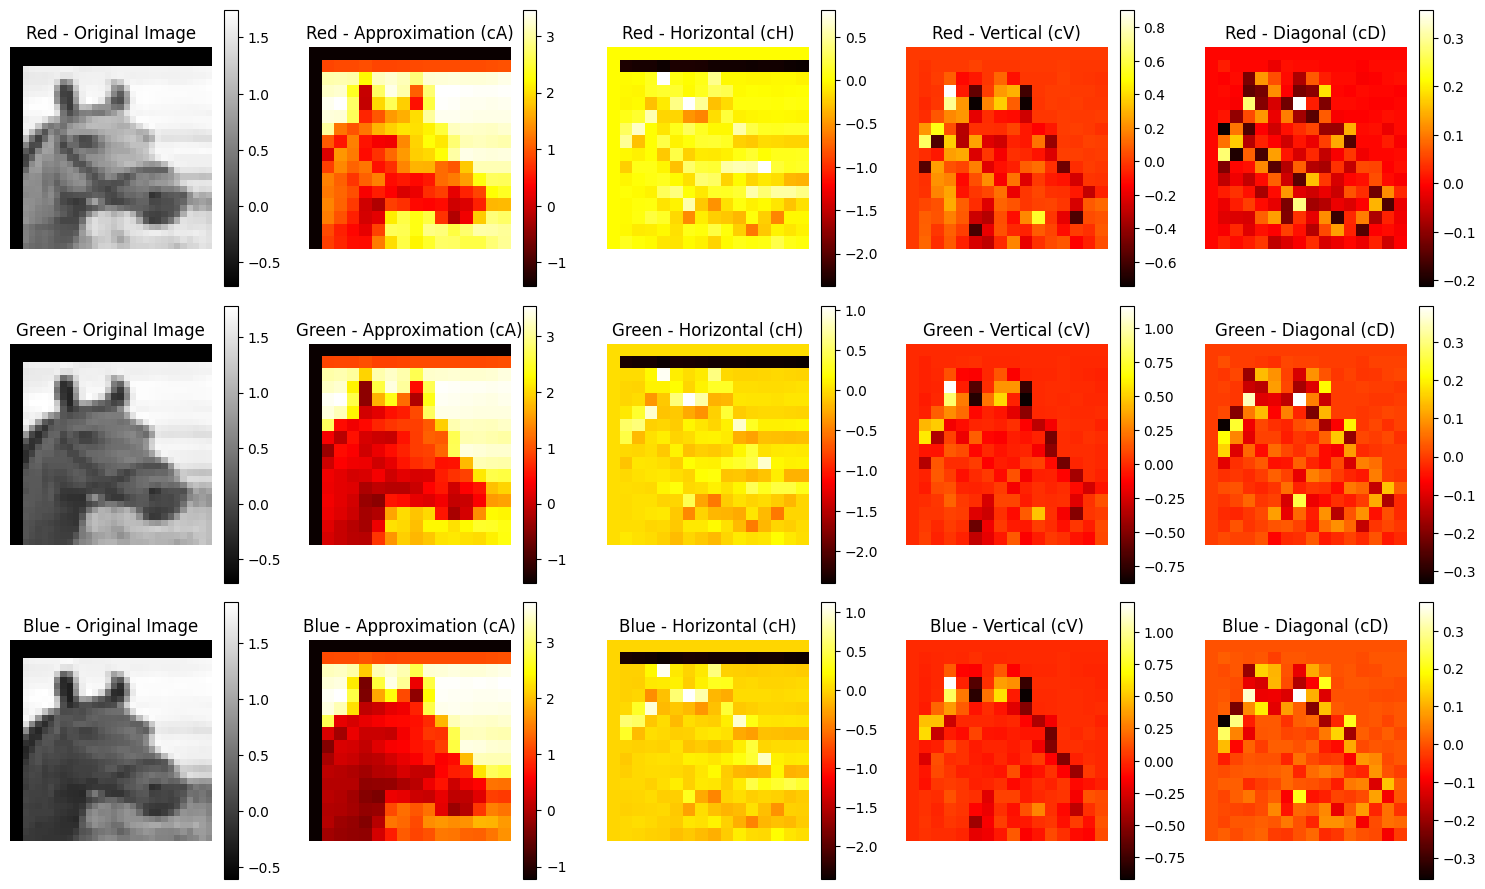

In [ ]:
def denormalize(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_wavelet_coeffs(image, wavelet_name='haar'):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    titles = ['Original Image', 'Approximation (cA)', 'Horizontal (cH)', 'Vertical (cV)', 'Diagonal (cD)']

    for i, color in enumerate(['Red', 'Green', 'Blue']):
        channel = image[:, :, i]

        wavelet = pywt.Wavelet(wavelet_name)
        cA, (cH, cV, cD) = pywt.dwt2(channel, wavelet)

        coeffs = [channel, cA, cH, cV, cD]

        for j in range(5):
            ax = axes[i, j]
            if j == 0:
                im = ax.imshow(coeffs[j], cmap='gray', interpolation='nearest')
            else:
                im = ax.imshow(coeffs[j], cmap='hot', interpolation='nearest')
            ax.set_title(f'{color} - {titles[j]}')
            ax.axis('off')
            fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

image_np = denormalize(images[99])

plot_wavelet_coeffs(image_np)